In [1]:
'''
45325919, Anthony Cerqui
https://github.com/littletuna4/bism3206-assign
'''

'\n45325919, Anthony Cerqui\nhttps://github.com/littletuna4/bism3206-assign\n'

In [1]:

#Use this cell to import all the required libraries.
# %pip install gensim colorama nltk scikit-learn matplotlib seaborn pandas numpy scipy<1.13 ipykernel openpyxl vadersentiment tables


# Set up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from colorama import Fore, Style
import itertools
from multiprocessing import Pool, cpu_count
from multiprocessing.pool import ThreadPool
import gc
from tqdm import tqdm
from scipy.sparse import dok_matrix


# Validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

# SMOTE
from imblearn.over_sampling import SMOTE


# NLP  stuff
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.chunk import ne_chunk
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


#Linear Dim Reduction
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

# non-linear Dim Reduction (tsne, isomap, lle)
from sklearn.manifold import TSNE
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding

# Vanilla Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#NNs
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense, LSTM


# nltk downloads
nltk.download('punkt')
nltk.download('words')
nltk.download('maxent_ne_chunker')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


def deco(a_string):
  return Style.BRIGHT+Fore.BLUE+a_string+Style.RESET_ALL
def render_cm(cm):
    plt.matshow(cm)
    # label extensively
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    # and tn, fp, fn, tp, accuracy, precision, recall, f1
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    # as text on plot 
    textargs = {'color':'white', 'ha':'center', 'va':'center', 'backgroundcolor':'black'}
    plt.text(0,0,f"tn: {tn:.2f}", **textargs)
    plt.text(1,0,f"fp: {fp:.2f}", **textargs)
    plt.text(0,1,f"fn: {fn:.2f}", **textargs)
    plt.text(1,1,f"tp: {tp:.2f}", **textargs)
    plt.text(2,0,f"accuracy: {accuracy:.2f}", **textargs)
    plt.text(2,1,f"precision: {precision:.2f}", **textargs)
    plt.text(0,1.75,f"recall: {recall:.2f}", **textargs)
    plt.text(1,1.75,f"f1: {f1:.2f}", **textargs)
    plt.show()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\seems\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\seems\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\seems\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\seems\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\seems\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\seems\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]    

In [2]:
# #your work should only start with the following code
# df=pd.read_excel("Assignment_Data.xlsx")

# # Trim it up for dev purposes we only want say 1%
# df = df.sample(frac=0.01, random_state=1)
# # save to csv
# df.to_csv("Assignment_Data_1pc.csv", index=False)

# df = pd.read_csv("Assignment_Data_1pc.csv")

# Retreive from checkpoint
# mdf.to_csv("data_checkpoint2.csv", index=False)
mdf = pd.read_hdf("data_checkpoint5.h5", key="mdf")


#### <font color="red"> When you are preparing your assignment, you can use as many cells as you want. However, before submitting, please ensure that you consolidate all the necessary codes for each section into a single cell according to the template requirements. Failing to follow the template will lead to a loss of marks.

# Data exploration

_In this cell, in no more than 200 words, you can elaborate on the major understanding of data based on your data exploration._

The dataset relates to social media data, containing information about news authors, headlines, tweets, and various metrics about user engagement and demographic details. It has a total of 134,198 entries across 16 features, without duplicate entries, indicating good data cleanliness in terms of redundancy. Several features have a significant amount of missing data, particularly user_following and user_country, which could impact analysis related to user demographics and behavior.

The descriptive statistics reveal a highly skewed distribution in engagement metrics (post_replies, post_retweets, post_favourites, post_quotes), with most posts receiving zero engagement but a few outliers receiving extremely high interaction, suggesting viral behavior for a minority of posts. User metrics like user_followers, user_favourites, and user_tweets_count also display wide variances, indicating a diverse user base from minimally active to influential users.

Misinformation flagged in roughly half of the entries (mean=0.514), highlighting the dataset's utility for studying the spread and impact of misinformation across social platforms. The data includes a variety of unique authors, headlines, and tweets, which can be useful for textual analysis and pattern recognition in social media discussions. The significant presence of missing values, especially in demographic-related columns, suggests a need for careful handling and possibly imputation techniques for more robust analyses.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134198 entries, 0 to 134197
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   news_author             134198 non-null  object 
 1   news_headline           134130 non-null  object 
 2   related_tweet           134150 non-null  object 
 3   post_replies            134175 non-null  float64
 4   post_retweets           134198 non-null  int64  
 5   post_favourites         134198 non-null  int64  
 6   post_quotes             134198 non-null  int64  
 7   user_followers          134170 non-null  float64
 8   user_following          44732 non-null   float64
 9   user_friends            134103 non-null  float64
 10  user_mentions           134143 non-null  float64
 11  user_favourites         134170 non-null  float64
 12  user_tweets_count       134166 non-null  float64
 13  user_tweet_count_lists  134179 non-null  float64
 14  user_country        

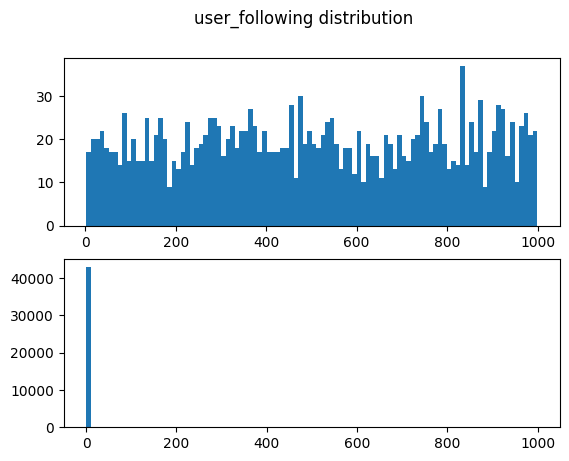

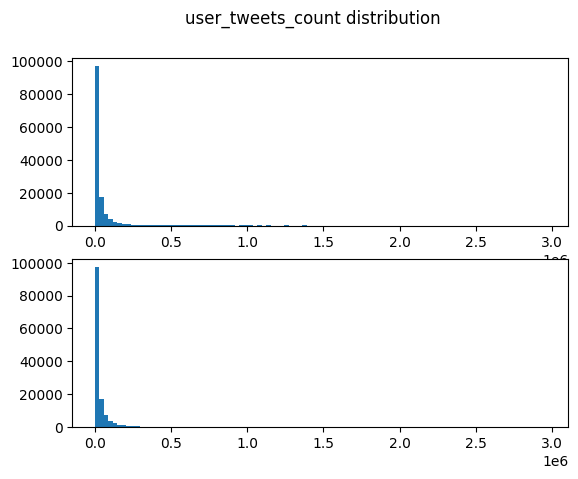

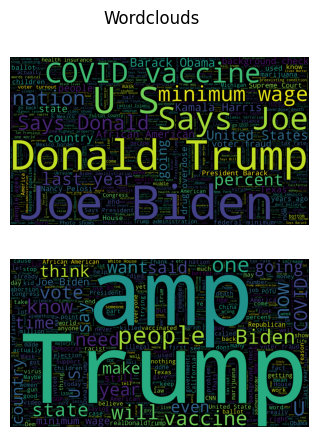

In [4]:
#Use this cell for data exploration.



# here's some general first-pass stuff
print(
    deco("df.head()\n"),df.head(),
    deco("df.info()\n"),df.info(),
    deco("df.describe()\n"),df.describe(),
    deco("df.columns\n"),df.columns,
    deco("df.shape\n"),df.shape,
    deco("df.isnull().sum()\n"),df.isnull().sum(),
    deco("df.duplicated().sum()\n"),df.duplicated().sum(),
    deco("df.nunique()\n"),df.nunique(),
    sep="\n"
)
# what are the unique types of each object column?   
print(
    deco("df.apply(lambda x: x.apply(lambda y: type(y)).value_counts(dropna=False))\n"),df.apply(lambda x: x.apply(lambda y: 'nan' if pd.isnull(y) else str(type(y))).value_counts()),
    sep="\n"
)

# Here's some more specific details after asking myself some questions
# What are the 161 unique news_authors? 
print(
    deco("df['news_author'].unique()\n"),df['news_author'].unique(),
    sep="\n"
)
# only 161 unique authors, that's not too bad and they're all well formatted. also, no doubt, these will be a good indicator; some will be more prone to missinformation. I probably won't process them much if at all - I'll just use them as a feature.



# the countries about an even split of string and nans - lets see how the text ones are distributed (also, lets check the form of the misinformation column)
print(
    deco("df['user_country'].value_counts()\n"),df['user_country'].value_counts(),
    deco("df['misinformation'].value_counts()\n"),df['misinformation'].value_counts(), # roughly even split 1.0, and 0.0
    sep="\n"
)
# mostly "US", and some "AU" - not many au though - I'll probably just drop this column
# lets compare the ratio of ratio of misinformation to not misinformation in the US and AU and other
print(
    deco("df[df['user_country']=='US']['misinformation'].value_counts(normalize=True)\n"),df[df['user_country']=='US']['misinformation'].value_counts(normalize=True), 
    deco("df[df['user_country']=='AU']['misinformation'].value_counts(normalize=True)\n"),df[df['user_country']=='AU']['misinformation'].value_counts(normalize=True),
    deco("df[df['user_country'].isnull()]['misinformation'].value_counts(normalize=True)\n"),df[df['user_country'].isnull()]['misinformation'].value_counts(normalize=True),
    sep="\n"
)
# Straight up, this column is not looking useful by itself - it'll only be considered for Simpon's paradox purposes - but that seems a hell of a stretch

# let's compare the ratio of misinformation to not misinformation for the user_following column - if the nan's have a different ratio to the 0's then, we should definetely use something better than just replacing them with 0
print(
    Fore.GREEN+Style.BRIGHT+"userFollowing\n"+Style.RESET_ALL,
    deco("df[df['user_following'].isnull()]['misinformation'].value_counts(normalize=True)\n"),df[df['user_following'].isnull()]['misinformation'].value_counts(normalize=True),
    deco("df[df['user_following']==0]['misinformation'].value_counts(normalize=True)\n"),df[df['user_following']==0]['misinformation'].value_counts(normalize=True),
    # then for neither
    deco("df[(df['user_following'].isnull())or(df['user_following']==0)]['misinformation'].value_counts(normalize=True)\n"),df[(df['user_following'].isnull())|(df['user_following']==0)]['misinformation'].value_counts(normalize=True),
    sep="\n"  
)

# lets check the "user_following" col for distribution - lots of nans - lets see how the floats are distributed using a histogram of the frequency distribution of the non-nans and non-zeros
# fig, ax = plt.subplots() 
fig, axs = plt.subplots(2, 1)
fig.suptitle('user_following distribution')
axs[1].hist(df['user_following'].dropna(), bins=100)
axs[0].hist(df['user_following'].replace(0,np.nan).dropna(), bins=100)

# do the samefor the user_tweets_count column
fig, axs = plt.subplots(2, 1)
fig.suptitle('user_tweets_count distribution')
axs[1].hist(df['user_tweets_count'].dropna(), bins=100)
axs[0].hist(df['user_tweets_count'].replace(0,np.nan).dropna(), bins=100)


'''
these are the cols with relatively few nulls - let's see how many rows we'd lose if we dropped them (as a fraction of the whole data set)
news_headline -> drop
    related_tweet -> drop
    post_replies -> drop
    user_followers -> drop
    user_friends -> drop
    user_mentions -> drop
    user_favourites -> drop
    user_tweets_count -> drop
    user_tweet_count_lists -> drop
    misinformation -> drop 
'''
print(
    deco("df[['news_headline','related_tweet','post_replies','user_followers','user_friends','user_mentions','user_favourites','user_tweets_count','user_tweet_count_lists','misinformation']].dropna().shape[0]/df.shape[0]\n"),df[['news_headline','related_tweet','post_replies','user_followers','user_friends','user_mentions','user_favourites','user_tweets_count','user_tweet_count_lists','misinformation']].dropna().shape[0]/df.shape[0],
    sep="\n"
)
# .996 remains - thats fine to drop 'em

# lets review if the misinformation column is balance by getting unique counts of misinformation
df["misinformation"].value_counts() #looks about even :) won't have to resample

# finally, lets run a wordcloud on the news_headline and tweet columns - that'll give us a good idea of the most common words and maybe the topics
wc = WordCloud(width=1600, height=900, max_words=1000).generate(' '.join(df['news_headline'].dropna()))
wc2 = WordCloud(width=1600, height=900, max_words=1000).generate(' '.join(df['related_tweet'].dropna()))
fig, axs = plt.subplots(2,1)
fig.suptitle('Wordclouds')
axs[0].imshow(wc)
axs[0].axis('off')
axs[1].imshow(wc2)
axs[1].axis('off')
plt.show()



# Text preparation

In this cell, in no more than 150 words, you can elaborate on the the innovativeness and depth of your work on text preparation.

In [4]:

#Use this cell for text preparation.

# So it's easy to follow lets build the model df from scratch instead of ontop of the original df
mdf = pd.DataFrame()


'''
Null handling:
We don't really want to drop rows if it can be avoided, so we'll fill the null values with a placeholder where we can.
    Headlines -> drop
    Tweets -> drop
    post_replies -> drop
    user_followers -> drop
    user_friends -> drop
    user_mentions -> drop
    user_favourites -> drop
    user_tweets_count -> drop
    user_tweet_count_lists -> drop
    misinformation -> drop 
    User_following -> 0 (assuming they're not following anyone, far too many to drop)
    User_country -> "Other" (assuming they're not from the US or AU, far too many to drop)
'''
df_nulls_handled = df.copy()

# get a mask of the rows with nulls in the columns we want to drop
rows_to_drop = df[['news_headline','related_tweet','post_replies','user_followers','user_friends','user_mentions','user_favourites','user_tweets_count','user_tweet_count_lists','misinformation']].isnull().any(axis=1)
df_nulls_handled = df_nulls_handled[~rows_to_drop] # drop them

# fill the user following and user_country columns
df_nulls_handled['user_following'] = df_nulls_handled['user_following'].fillna(0)
df_nulls_handled['user_country'] = df_nulls_handled['user_country'].fillna("Other")

# put the nulls_handled "misinformation" column into the new dataframe
mdf['misinformation'] = df_nulls_handled['misinformation']


'''
Lowercasing:
We can remove the case sensitivity of the text by converting all the words to lowercase.
'''
# I will apply this to the "news_headline" and "related_tweet" columns and add the lowercase versions to the new dataframe
mdf['headline_lower'] = df_nulls_handled['news_headline'].apply(lambda x: x.lower())
mdf['tweet_lower'] = df_nulls_handled['related_tweet'].apply(lambda x: x.lower())


'''
Stopword removal
We can remove unimportant words to reduce the computation load and improve the potency of the training data
'''
mdf['headline_lower'] = mdf['headline_lower'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))]))

mdf['tweet_lower'] = mdf['tweet_lower'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))]))

'''
Punctuation and special character removal
Much like stopword removal, this technique is good for omitting unimportant data.
'''
mdf['headline_lower'] = mdf['headline_lower'].apply(lambda x: re.sub(r'[^\w\s]','',x))
mdf['tweet_lower'] = mdf['tweet_lower'].apply(lambda x: re.sub(r'[^\w\s]','',x))

'''
Tag Extraction
In twitter posts, we can extract tagged users by looking for words that start with a @ symbol, and tagged concepts by looking for words that start with a # symbol.
It's not as simple as just splitting the text by spaces, as the tags can be attached to words. so we'll split the text by spaces, filter for those with "@" or "#" in them at all, then split them by those symbols and remove the first element
# ADVANCED?
'''
# Regex to find mentions and hashtags respectively
extract_mentions = lambda text : re.findall(r'(?:(?<=\s)|(?<=^))@\w[\w.]*', text)
extract_hashtags = lambda text: re.findall(r'#\w+', text)
mdf['mentions'] = df_nulls_handled['related_tweet'].apply(extract_mentions)
mdf['hashtags'] = df_nulls_handled['related_tweet'].apply(extract_hashtags)
# then lets get counts
mdf['mentions_count'] = mdf['mentions'].apply(len)
mdf['hashtags_count'] = mdf['hashtags'].apply(len)


'''
stemming
Stemming is a technique used to reduce words to their root form.
we can use the nltk library to stem words in the text.
'''
stemmer = nltk.stem.PorterStemmer()
mdf['headline_stemmed'] = mdf['headline_lower'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
mdf['tweet_stemmed'] = mdf['tweet_lower'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))


'''
lemmatization
lemmatization is another technique used to reduce words to their root form.
'''
lemmatizer = nltk.stem.WordNetLemmatizer()
mdf['headline_lemmatized'] = mdf['headline_lower'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
mdf['tweet_lemmatized'] = mdf['tweet_lower'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))



# finally lets take a look at the input dataframe
print(
    deco("mdf.head()\n"),mdf.head(),
    deco("mdf.info()\n"),mdf.info(),
    deco("mdf.describe()\n"),mdf.describe(),
    deco("mdf.columns\n"),mdf.columns,
    deco("mdf.shape\n"),mdf.shape,
    deco("mdf.isnull().sum()\n"),mdf.isnull().sum(),
    # deco("mdf.duplicated().sum()\n"),mdf.duplicated().sum(),
    # deco("mdf.nunique()\n"),mdf.nunique(),
    sep="\n"
)

# save to csv
mdf.to_hdf("data_checkpoint1.h5", index=False, key="mdf", mode="w")

NameError: name 'deco' is not defined

In [2]:
mdf.to_hdf("data_checkpoint1.h5", index=False, key="mdf", mode="w")


NameError: name 'mdf' is not defined

# Feature engineering

In this cell, in no more than 150 words, you can elaborate on the the innovativeness of your work on feature generation.

##### Feature 1 generation

In [ ]:
#Use this cell for text feature_1 generation.

'''
Vadar sentiment
Vadar sentiment is a simple-to-execute technique used to determine the sentiment of a text.
It understands the punctuation and capitalisation of the text, so we will use it on the the raw text.
'''
mdf['sentiment'] = df['related_tweet'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(str(x))['compound'])

# save to csv
mdf.to_hdf("data_checkpoint2.h5", index=False, key="mdf", mode='w')


C:\Users\seems\AppData\Local\Temp\ipykernel_29880\2563893285.py:11: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['headline_lower', 'tweet_lower', 'mentions', 'hashtags',
       'headline_stemmed', 'tweet_stemmed', 'headline_lemmatized',
       'tweet_lemmatized'],
      dtype='object')]

  mdf.to_hdf("data_checkpoint2.h5", index=False, key="mdf", mode='w')


In [3]:
'''
Bag Of words
The bag of words model is a simple model that represents text data as a bag of words.
It ignores order and grammar, and only considers the frequency of words in the text - it also serves as
the input to TLF-IDF and Word2Vec models.
'''
# then we'll tokenize the text with punkt
mdf['tokens'] = ( mdf['headline_lower'] + " " + mdf['tweet_lower']).apply(word_tokenize)

# mdf.to_hdf("data_checkpoint3.h5", index=False, key="mdf", mode='w')


'''We'll alos make a dictionary and corpus of the bag of words - this will be useful for the LDA model, we'll also prepare a tfidf model against the corpus'''
# we'll use the tokens to create a dictionary and a corpus
dictionary = corpora.Dictionary(mdf['tokens'])
corpus = [dictionary.doc2bow(text) for text in mdf['tokens']]
'''
TFIDF -
TFIDF is a measure of how important a word is in a document.
It is calculated by multiplying the term frequency of a word in a document by the
inverse document frequency of the word across all documents.
'''
tfidf = gensim.models.TfidfModel(corpus)
# and apply it to the corpus
mdf['tfidf'] = tfidf[corpus]

# mdf.to_hdf("data_checkpoint4.h5", index=False, key="mdf", mode='w')

# dimensionality reduction/svd


In [4]:
'''
# lets tokenise and vectorise the tags.
# we'll use the tokens to create a dictionary and another corpus
'''
mentiondictionary = corpora.Dictionary(mdf['mentions'])
hashtagdictionary = corpora.Dictionary(mdf['hashtags'])
mentioncorpus = [mentiondictionary.doc2bow(text) for text in mdf['mentions']]
hashtagcorpus = [hashtagdictionary.doc2bow(text) for text in mdf['hashtags']]
'''
# we'll use the tokens to create a dictionary and another corpus
'''
mentiontfidf = gensim.models.TfidfModel(mentioncorpus)
hashtagtfidf = gensim.models.TfidfModel(hashtagcorpus)
# and apply it to the corpus
mdf['mentionstfidf'] = mentiontfidf[mentioncorpus]
mdf['hashtagstfidf'] = hashtagtfidf[hashtagcorpus]

# mdf.to_hdf("data_checkpoint5.h5", index=False, key="mdf", mode='w')


'''
# lets take a look at the input dataframe
'''
mdf

,misinformation,headline_lower,tweet_lower,mentions,hashtags,mentions_count,hashtags_count,headline_stemmed,tweet_stemmed,headline_lemmatized,tweet_lemmatized,sentiment,tokens,tfidf,mentionstfidf,hashtagstfidf
0,1.0,new york passed the best paid family leave pro...,joebiden praising cuomos accomplishments paid ...,[],[],0,0,new york pass the best paid famili leav progra...,joebiden prais cuomo accomplish paid famili le...,new york passed the best paid family leave pro...,joebiden praising cuomos accomplishment paid f...,-0.1280,"[new, york, passed, the, best, paid, family, l...","[(0, 0.22547016209176093), (1, 0.1000583857064...",[],[]
1,0.0,busted cdc inflated covid numbers accused viol...,magicjordan702 moses13490917 ragnaeyjadottir c...,"[@MagicJordan702, @Moses13490917, @RagnaEyjado...",[],4,0,bust cdc inflat covid number accus violat fede...,magicjordan702 moses13490917 ragnaeyjadottir c...,busted cdc inflated covid number accused viola...,magicjordan702 moses13490917 ragnaeyjadottir c...,-0.4215,"[busted, cdc, inflated, covid, numbers, accuse...","[(33, 0.19438614363078593), (34, 0.14880562643...","[(0, 0.23117293066754793), (1, 0.5617113956848...",[]
2,1.0,states hit hardest opioid deaths have opioid p...,kaatjim timflannery2 growing problem everywher...,"[@KaatJim, @TimFlannery2]",[],2,0,state hit hardest opioid death have opioid pre...,kaatjim timflannery2 grow problem everywher li...,state hit hardest opioid death have opioid pre...,kaatjim timflannery2 growing problem everywher...,-0.2500,"[states, hit, hardest, opioid, deaths, have, o...","[(24, 0.07048199981916174), (44, 0.10280372227...","[(4, 0.7071067811865476), (5, 0.70710678118654...",[]
3,1.0,when saw corruption sexual harassment coverups...,quinnipiacpoll margin 51 22 voters say assembl...,[],[],0,0,when saw corrupt sexual harass coverup call sh...,quinnipiacpol margin 51 22 voter say assembl s...,when saw corruption sexual harassment coverups...,quinnipiacpoll margin 51 22 voter say assembly...,-0.6486,"[when, saw, corruption, sexual, harassment, co...","[(78, 0.14957933105457885), (79, 0.22640918354...",[],[]
4,0.0,eisenhower interstate system requires one mile...,fact eisenhower interstate system requires one...,[],[#fact],0,1,eisenhow interst system requir one mile everi ...,fact eisenhow interst system requir one mile e...,eisenhower interstate system requires one mile...,fact eisenhower interstate system requires one...,-0.6808,"[eisenhower, interstate, system, requires, one...","[(99, 0.20778769216703694), (100, 0.1398543616...",[],"[(0, 1.0)]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134193,1.0,says barack obama played 90 rounds golf president,seemslikeaprilfoolsbutitsnot despite laserlike...,[],[#SeemsLikeAprilFoolsButItsNot],0,1,say barack obama play 90 round golf presid,seemslikeaprilfoolsbutitsnot despit laserlik f...,say barack obama played 90 round golf president,seemslikeaprilfoolsbutitsnot despite laserlike...,0.0000,"[says, barack, obama, played, 90, rounds, golf...","[(23, 0.04667395628753538), (196, 0.0883428401...",[],"[(11494, 1.0)]"
134194,0.0,says bidens rolex belonged late son beau,nathanhrubin occupydemocrats president bidens ...,"[@NathanHRubin, @OccupyDemocrats]",[],2,0,say biden rolex belong late son beau,nathanhrubin occupydemocrat presid biden rolex...,say bidens rolex belonged late son beau,nathanhrubin occupydemocrats president bidens ...,0.9380,"[says, bidens, rolex, belonged, late, son, bea...","[(18, 0.12141960008473505), (23, 0.03712631766...","[(1452, 0.6002220937497682), (16550, 0.7998333...",[]
134195,1.0,says according fbi people killed year hammers ...,talkmaster fbi stat ppl killed hammers clubs a...,[@talkmaster],[],1,0,say accord fbi peopl kill year hammer club rifl,talkmast fbi stat ppl kill hammer club assault...,say according fbi people killed year hammer cl...,talkmaster fbi stat ppl killed hammer club ass...,-0.8617,"[says, according, fbi, people, killed, year, h...","[(23, 0.048063

In [5]:
# tfidf to vectors: for the 3 tfidf columns, we want to blow them out into their vectors
# tfidf values are lists of tuples of length 2 (the first is the key, the second it the value.), we want each key as a column (being careful not to double up for raw, mentions and hashtags)

# first convert each to a list of dicts. we rename the keys to avoid collisions
packed_tfidf_df = pd.DataFrame()
packed_tfidf_df['tfidf_dicts'] = mdf['tfidf'].apply(lambda x: {f"tfidf_{k}":v for k,v in x})
packed_tfidf_df['mentionstfidf_dicts'] = mdf['mentionstfidf'].apply(lambda x: {f"mentionstfidf_{k}":v for k,v in x})
packed_tfidf_df['hashtagstfidf_dicts'] = mdf['hashtagstfidf'].apply(lambda x: {f"hashtagstfidf_{k}":v for k,v in x})

packed_tfidf_df["combined"] = packed_tfidf_df.apply(lambda row: {**dict(row['tfidf_dicts']), **dict(row['mentionstfidf_dicts']), **dict(row['hashtagstfidf_dicts'])}, axis=1)
print("Packed TF-IDF data into single dictionary")


Packed TF-IDF data into single dictionary


In [8]:

# the memory use to unpack this directly is more than feasible, so we'll prep the structure and some sparse arrays and then unpack them into the preparred sparse arrays (these handle a bunch of zeros well)
# keys = [f"tfidf_{k}" for k in list(dictionary.token2id.values())] + [f"mentionstfidf_{k}" for k in list(mentiondictionary.token2id.values())] + [f"hashtagstfidf_{k}" for k in list(hashtagdictionary.token2id.values())]

# Generate keys for sparse DataFrame columns
gen1 = (f"p_{k}" for k in dictionary.token2id.values())
gen2 = (f"m_{k}" for k in mentiondictionary.token2id.values())
gen3 = (f"h_{k}" for k in hashtagdictionary.token2id.values())
keys = list(np.fromiter(itertools.chain(gen1, gen2, gen3), dtype='U50'))

# Function to process each row into a sparse series
def process_row(row_dict):
    row_data = {key: row_dict.get(key, 0) for key in keys}
    sparse_series = pd.Series(row_data).astype(pd.SparseDtype("float", 0))
    return sparse_series


# Pre-allocate a list to collect Sparse Series
sparse_series_list = []

# Process each row, convert to sparse series, and collect
for _, row in packed_tfidf_df.iterrows():
    processed = process_row(row['combined'])
    sparse_series_list.append(processed)

# Create a Sparse DataFrame from the list of Sparse Series
tfidf_df = pd.concat(sparse_series_list, axis=1).transpose()

# Optional: Save to HDF5
tfidf_df.to_hdf("sparse_tfidf_checkpoint.h5", key="tfidf_df", mode='w')

# Show structure and shape
print(tfidf_df)
print(tfidf_df.shape)

tfidf_df.to_hdf("tfidf checkpoint.h5", index=False, key="tfidf_df", mode='w')
tfidf_df, tfidf_df.shape # a whole lot of columns so we won't add to the main df just yet


In [ ]:
# apply some dimensionality reduction to the tfidf vectors
svd = TruncatedSVD(n_components=100)
svd.fit(tfidf_df)
svd_tfidf_df = pd.DataFrame(svd.transform(tfidf_df))
svd_tfidf_df.columns = [f"svd_{i}" for i in svd_tfidf_df.columns]
# use the old index
svd_tfidf_df.index = tfidf_df.index
svd_tfidf_df # 100 columns, much more manageable




,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,...,svd_90,svd_91,svd_92,svd_93,svd_94,svd_95,svd_96,svd_97,svd_98,svd_99
0,0.029031,0.098621,-0.087726,0.019954,-0.049778,0.025213,0.024683,-0.054838,-0.068193,-0.001788,...,-0.071817,0.003167,0.003773,-0.036910,-0.101436,0.085877,-0.055843,0.017933,-0.051305,-0.036262
1,0.040914,0.094518,0.004146,-0.081489,-0.006873,-0.021197,0.010788,0.189216,-0.159845,-0.101736,...,-0.051008,-0.008463,0.020733,-0.022408,0.044672,-0.001536,0.060666,0.012796,0.049723,0.019904
2,0.013795,0.072615,0.017838,-0.117972,0.048192,-0.051664,0.029225,-0.101349,0.046352,-0.093819,...,0.031741,0.014363,-0.062223,-0.062249,0.021705,0.019863,0.007750,-0.046362,-0.051837,-0.041236
3,0.041987,0.134306,0.042525,-0.187790,0.053573,-0.082494,0.055454,-0.152540,0.047724,-0.138036,...,0.028318,0.015517,0.037101,-0.063161,-0.038984,-0.047240,0.016430,-0.022481,0.037574,0.037723
4,0.019331,0.068906,0.001035,-0.038148,0.004186,-0.015487,0.001427,0.004626,0.006277,-0.003088,...,-0.010604,0.084718,-0.018592,0.050140,0.029829,0.163497,0.105651,-0.057305,0.023492,0.081333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,0.306111,-0.019513,0.029856,-0.007659,-0.001323,-0.010213,-0.009026,-0.014300,0.016209,-0.016241,...,-0.013011,-0.047018,0.005432,0.023307,0.042113,0.069784,0.008929,0.106822,0.067822,-0.018068
1338,0.013019,0.058730,0.006503,-0.078573,0.017638,-0.028098,0.040185,-0.043933,-0.001671,-0.028200,...,-0.020595,0.014193,-0.039102,-0.054102,0.005829,-0.049553,0.012513,0.028467,0.036311,0.004060
1339,0.018028,0.054771,0.011267,-0.030354,0.014170,-0.010028,-0.016130,0.011715,-0.010599,-0.003946,...,-0.004850,0.013522,0.012470,-0.050382,-0.008693,0.019168,-0.020076,0.007823,0.003931,-0.006758
1340,0.026132,0.137174,-0.091750,0.158496,0.304826,-0.003765,0.081861,-0.012920,0.022345,-0.062026,...,-0.059503,-0.090243,-0.016861,-0.050781,-0.029104,0.011462,-0.006409,0.075934,0.041331,-0.060965


In [ ]:
# lets try a non-linear method too
tsne = TSNE(n_components=3)
tsne.fit(tfidf_df)
tsne_tfidf_df = pd.DataFrame(tsne.fit_transform(tfidf_df))
tsne_tfidf_df.columns = [f"tsne_{i}" for i in tsne_tfidf_df.columns]
tsne_tfidf_df 

,tsne_0,tsne_1,tsne_2
0,6.712220,-4.943687,-9.374645
1,27.285458,-21.811201,-10.469926
2,-41.732082,-9.348600,-9.849624
3,-13.463915,-29.880659,-10.786694
4,13.340328,12.259937,-40.263432
...,...,...,...
1334,-20.333271,22.841923,-13.841755
1335,5.027600,-2.594756,-35.220631
1336,-13.132774,-2.029727,8.672191
1337,2.960543,-18.629629,-15.500089


In [ ]:
# ISOmap dim reductiosn

isomap = Isomap(n_components=100)
isomap.fit(tfidf_df)
isomap_tfidf_df = pd.DataFrame(isomap.fit_transform(tfidf_df))
isomap_tfidf_df.columns = [f"isomap_{i}" for i in isomap_tfidf_df.columns]
isomap_tfidf_df

,isomap_0,isomap_1,isomap_2,isomap_3,isomap_4,isomap_5,isomap_6,isomap_7,isomap_8,isomap_9,...,isomap_90,isomap_91,isomap_92,isomap_93,isomap_94,isomap_95,isomap_96,isomap_97,isomap_98,isomap_99
0,1.857294,-1.243458,-0.464320,-1.644660,0.476840,0.090111,-0.320429,-0.845268,-0.152528,-1.126829,...,-0.025692,-0.189555,0.323343,0.270798,0.038561,0.118195,0.065821,-0.073591,-0.052087,-0.390662
1,1.841652,-1.718145,-1.861157,-0.705930,1.694761,0.101033,-0.865858,0.667429,-1.359838,-1.171522,...,0.788057,-0.248260,0.261449,-0.185317,0.020338,-0.238516,-0.110803,0.055302,0.084342,0.271680
2,-2.734667,0.479696,0.271683,0.971110,0.607052,-0.453559,-0.569512,-0.252712,-0.352477,0.073284,...,0.563738,-0.331051,0.382409,0.221945,0.257366,0.208425,-0.373840,0.168279,-0.056049,0.324802
3,-1.258047,-0.657124,0.594152,-0.552341,0.865204,-0.713271,-0.457142,-2.209552,-0.504934,-1.007754,...,-0.055189,-0.148445,-0.048651,-0.353304,-0.619360,0.040785,-0.209355,0.343570,-0.296041,0.056536
4,-0.085411,0.128410,1.381009,0.338395,-1.176692,0.754699,-1.346788,-0.274287,-0.816466,-0.071701,...,0.018941,-0.602754,0.284030,0.085469,0.741166,0.221030,-0.394423,0.282122,0.248919,0.479751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,-2.472927,-1.075886,2.263150,0.322219,0.044576,-0.229350,-0.434253,0.170343,-0.811275,-0.437272,...,-0.095339,-0.198962,0.067734,-0.003723,-0.123760,-0.172732,-0.217208,-0.209173,-0.130411,0.039238
1335,-0.433193,0.694082,1.624769,0.785083,-0.654718,0.578011,-1.673791,0.780075,-0.290905,0.261809,...,-0.152040,0.249685,-0.350062,-0.369058,-0.213704,1.143157,0.480682,0.880214,-0.249186,-0.300575
1336,0.028989,0.753544,-0.867293,-0.531422,-0.498169,-1.220744,-0.057524,-0.269714,0.179732,0.059777,...,-0.264465,-0.451435,0.441590,-0.033449,0.002463,-0.395233,0.096627,0.291643,0.038678,0.046247
1337,0.660337,-1.547292,-0.141859,-1.433386,-1.176113,-0.911457,-1.713226,0.266879,1.501741,-0.662408,...,-0.499114,0.389029,0.699353,-0.248080,0.104570,-0.417391,-0.528093,0.130938,-0.349060,-0.379294


Feature 2 generation

In [ ]:
'''
LDA (Latent Dirichlet Allocation) (its pretty much a standard dim reduction)
LDA is a technique used to extract topics from a text.
It is useful for understanding the underlying themes of a text.
The output is a list of topics, each with a list of words that represent the topic.
It can be applied to the bag of words model
In comparison to tfidf, LDA is a more advanced technique that can extract topics from a text.
'''
n_topics = 4

ldaModel = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topics, passes=10)
topics = ldaModel.print_topics()
for topic in topics:
    print(topic)


# now we want to get a column for each topic that we can use as features on each of the twitter posts
# we'll use the tfidf model to get the topic distribution
print([ldaModel.get_document_topics(text) for text in mdf['tfidf']])
topic_dist = [ [score for topic_index, score in line] for line in[ldaModel.get_document_topics(text) for text in mdf['tfidf']]]

# then we'll make a dataframe from the topic distribution
topicdf = pd.DataFrame(topic_dist, columns=[f"topic_{i}" for i in range(n_topics)])
# reset the index
topicdf.index = mdf.index

'''
Viewing the topic distribution, it seems that the theres a lot of overlap between the topics - this is likely due to the small size of the dataset
Highly political
War on drugs?
'''
topicdf




(0, '0.010*"trump" + 0.007*"says" + 0.006*"minimum" + 0.005*"wage" + 0.005*"years" + 0.004*"marijuana" + 0.004*"people" + 0.004*"federal" + 0.003*"biden" + 0.003*"americans"')
(1, '0.009*"tax" + 0.007*"americans" + 0.005*"states" + 0.005*"would" + 0.005*"taxes" + 0.004*"people" + 0.004*"biden" + 0.004*"amp" + 0.004*"highest" + 0.004*"1"')
(2, '0.012*"biden" + 0.009*"says" + 0.008*"people" + 0.007*"joe" + 0.006*"us" + 0.005*"world" + 0.005*"one" + 0.005*"trump" + 0.005*"white" + 0.004*"years"')
(3, '0.010*"vaccine" + 0.009*"covid" + 0.008*"says" + 0.006*"trump" + 0.006*"children" + 0.006*"covid19" + 0.004*"voter" + 0.004*"health" + 0.004*"fraud" + 0.004*"georgia"')
[[(0, 0.05989445), (1, 0.056032225), (2, 0.826958), (3, 0.057115316)], [(0, 0.04139462), (1, 0.040279593), (2, 0.46732712), (3, 0.45099863)], [(0, 0.0567361), (1, 0.055194236), (2, 0.054740433), (3, 0.83332926)], [(0, 0.05263838), (1, 0.052544992), (2, 0.05435522), (3, 0.8404614)], [(0, 0.03990386), (1, 0.041185383), (2, 0.87

,topic_0,topic_1,topic_2,topic_3
0,0.059830,0.056032,0.827023,0.057115
1,0.041376,0.040280,0.467433,0.450911
2,0.056734,0.055194,0.054740,0.833331
3,0.052639,0.052545,0.054379,0.840437
4,0.039904,0.041194,0.878042,0.040860
...,...,...,...,...
1337,0.620202,0.276981,0.050967,0.051850
1338,0.039545,0.044531,0.873190,0.042734
1339,0.044784,0.722890,0.186207,0.046119
1340,0.043441,0.872267,0.042907,0.041385


In [ ]:

'''
Word2Vec
Word2Vec is a technique used to represent words as vectors.
Suitable for preparing the data for neural networks models.
'''

word2vec = gensim.models.Word2Vec(mdf['tokens'], vector_size=100, window=1, min_count=1, workers=4)
# then we'll append the vectors to the dataframe
tokenvectorsdf = pd.DataFrame(
    mdf['tokens'].apply(
        lambda tokens: np.mean(
            [word2vec.wv[word] for word in tokens if word in word2vec.wv.key_to_index], axis=0
        ) if any(word in word2vec.wv.key_to_index for word in tokens) else np.zeros(word2vec.vector_size)
    ).tolist()
)

tokenvectorsdf.columns = [f"word2vec_{i}" for i in tokenvectorsdf.columns]
tokenvectorsdf.index = mdf.index
tokenvectorsdf


,word2vec_0,word2vec_1,word2vec_2,word2vec_3,word2vec_4,word2vec_5,word2vec_6,word2vec_7,word2vec_8,word2vec_9,...,word2vec_90,word2vec_91,word2vec_92,word2vec_93,word2vec_94,word2vec_95,word2vec_96,word2vec_97,word2vec_98,word2vec_99
0,-0.000166,0.005864,0.001703,-0.003534,0.000328,-0.007786,0.002251,0.010705,-0.002926,-0.004769,...,0.004470,0.001383,0.001383,-0.000826,0.008348,0.002281,0.004037,-0.006211,0.000522,-0.001893
1,-0.002697,0.003585,0.000283,0.000179,0.002102,-0.005103,0.001091,0.004697,-0.003582,-0.000484,...,0.001385,0.002225,0.000432,0.001138,0.005413,0.002553,0.000366,-0.002856,0.001544,0.000337
2,-0.002359,0.002989,0.000964,-0.001934,-0.000716,-0.004588,0.000516,0.005776,-0.004011,-0.000014,...,0.002487,0.004876,-0.002952,-0.001635,0.006771,0.001050,0.000874,-0.002715,0.002761,0.001803
3,0.000813,0.006109,0.003318,-0.000281,0.002530,-0.008660,-0.000350,0.009726,-0.002710,-0.004611,...,0.004997,0.004486,-0.000827,0.002073,0.008373,0.000946,0.001197,-0.002075,-0.002196,0.001938
4,-0.002728,0.001350,-0.000493,0.000944,0.001521,-0.002099,0.000022,0.001636,-0.002790,-0.000110,...,0.001403,0.000026,-0.000595,0.001138,0.002949,0.002514,0.002833,-0.002981,0.001444,-0.000529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,-0.003305,0.002713,-0.000766,-0.001678,0.001530,-0.005160,0.000316,0.005939,-0.004354,0.001193,...,0.003016,0.002952,0.000732,-0.001080,0.004783,0.003264,0.000510,-0.001406,0.001475,0.001236
1338,0.000046,0.002758,0.001629,0.002349,0.000883,-0.003365,-0.003435,0.004970,-0.003047,-0.001869,...,0.002384,0.001039,-0.001280,0.000592,0.004134,-0.000823,0.001361,-0.002747,0.000652,0.001042
1339,-0.000237,0.001014,0.003474,-0.000632,0.000483,-0.004027,0.001378,0.004082,-0.000699,-0.002991,...,0.001868,-0.000805,-0.001716,0.001211,0.003913,-0.000264,0.001603,0.000166,0.001919,0.003225
1340,-0.000724,0.001680,-0.001203,0.000910,0.000410,-0.003081,-0.001545,0.005138,-0.000867,-0.000452,...,0.001448,0.000007,0.000650,-0.001064,0.002387,0.002756,0.000142,-0.000767,0.000488,-0.001175


In [ ]:
'''
POS Tagging
Considers Grammatical features of words
'''
# we'll use the tokens to get the pos tags
word_pos_tag_series = mdf['tokens'].apply(lambda x:  nltk.pos_tag(x))
mdf['pos_tags'] = word_pos_tag_series.apply(lambda x: [y[1] for y in x])

'''
This can be used in the models as a feature
as it can be used to determine the grammatical structure of the text.
Perhaps useful as an indicator of low effort messages
'''
print(mdf['pos_tags'])


# we could use one hot encoding, but we'll lose some valuable information about the relationships between the tags
# So, we'll prepare this for an lstm model by padding the sequences and then converting the tags to their indices
# this will allow us to preserve the temporal relationships between the tags and hopefully allow us to 
# capture some of the grammatical structure of the text and thus some sense of credibility
pad = ''
# first we'll get the unique tags
unique_tags = set([tag for tags in mdf['pos_tags'] for tag in tags])
# add "" for padding
unique_tags.add(pad)
print(unique_tags)
# then we'll make a dict of the tags to their indices
tag2idx = {tag:i for i,tag in enumerate(unique_tags)}
# then we'll make a dict of the indices to their tags
idx2tag = {i:tag for i,tag in enumerate(unique_tags)}
# then we'll pad the sequences
maxlen = max([len(tags) for tags in mdf['pos_tags']])
mdf['pos_tags_array'] = mdf['pos_tags'].apply(lambda x: x + [pad]*(maxlen-len(x)))
# then we'll convert the tags to their indices
mdf['pos_tags_array'] = mdf['pos_tags_array'].apply(lambda x: [tag2idx[tag] for tag in x])
mdf['pos_tags_array'] # now we have a list of indices for each row, we can use this as a feature in a model - i'm thinking lstm

0       [VBZ, NN, NN, VBD, JJ, NN, NN, NN, VBD, NN, NN...
1       [JJ, NN, NN, NNS, VBD, JJ, NN, NN, NN, NN, NN,...
2       [NN, JJ, NN, VBD, JJ, NN, NN, VBD, NN, NN, NN,...
3       [NNS, VBP, NN, NN, VBZ, NNS, VBP, JJ, NN, CC, ...
4       [NNS, VBG, NN, VBD, JJ, IN, JJ, JJ, NNS, VBP, ...
                              ...                        
1337    [NN, VBZ, RBS, JJ, NN, NN, NN, JJ, NN, NNS, VB...
1338    [VBZ, NN, NN, VBD, NNS, VBP, JJ, NN, NNP, NN, ...
1339    [JJS, NN, NN, NN, VBD, CD, NNS, RB, VBD, JJ, C...
1340    [JJ, NNS, VBP, JJ, NN, NN, JJ, NN, NN, NN, NN,...
1341    [JJ, JJS, NN, JJ, NN, VBD, NNS, JJ, NN, NN, NN...
Name: pos_tags, Length: 1339, dtype: object
{'', 'JJS', 'RBR', 'UH', 'NN', 'PRP', 'MD', 'POS', 'CD', 'FW', 'DT', 'RP', 'PDT', 'TO', 'VBD', 'VBZ', 'RBS', 'NNPS', 'NNP', '$', 'CC', 'NNS', 'VBG', 'VB', 'VBP', 'WP', 'EX', 'JJR', 'RB', 'WDT', 'WP$', 'IN', 'VBN', 'WRB', 'JJ', 'PRP$'}


0       [15, 4, 4, 14, 34, 4, 4, 4, 14, 4, 4, 4, 28, 8...
1       [34, 4, 4, 21, 14, 34, 4, 4, 4, 4, 4, 4, 4, 31...
2       [4, 34, 4, 14, 34, 4, 4, 14, 4, 4, 4, 4, 32, 3...
3       [21, 24, 4, 4, 15, 21, 24, 34, 4, 20, 24, 4, 1...
4       [21, 22, 4, 14, 34, 31, 34, 34, 21, 24, 22, 4,...
                              ...                        
1337    [4, 15, 16, 34, 4, 4, 4, 34, 4, 21, 24, 34, 21...
1338    [15, 4, 4, 14, 21, 24, 34, 4, 18, 4, 4, 34, 4,...
1339    [1, 4, 4, 4, 14, 8, 21, 28, 14, 34, 8, 4, 4, 8...
1340    [34, 21, 24, 34, 4, 4, 34, 4, 4, 4, 4, 21, 4, ...
1341    [34, 1, 4, 34, 4, 14, 21, 34, 4, 4, 4, 1, 4, 4...
Name: pos_tags_array, Length: 1339, dtype: object

In [ ]:
'''
Named Entity Recognition
Identifies named entities in text
'''

# we have the pos tags already, so we can use them to get the named entities
namedEntitiesTrees  = word_pos_tag_series.apply(ne_chunk)

# now we extract the named entities from the trees
namedEntities = namedEntitiesTrees.apply(lambda x: [y for y in x if type(y) == nltk.Tree])
# then we'll get the labels of the named entities
namedEntitiesLabels = namedEntities.apply(lambda x: [y.label() for y in x])
# then we'll get the named entities themselves
namedEntities = namedEntities.apply(lambda x: [y[0] for y in x])

print(namedEntities.value_counts(), namedEntitiesLabels.value_counts()) # we can use these as features in a model, they might be useful for determining the credibility of the text

# It's not very usefull to us 
# if it were it would be hot encoded and then used as a feature in a model


tokens
[]                      1338
[(____54_____, NNP)]       1
Name: count, dtype: int64 tokens
[]                1338
[ORGANIZATION]       1
Name: count, dtype: int64


.
.
.

##### Feature N generation

In [ ]:
#Use this cell for text feature_N generation.

# Model Development
#### <font color="red">You must remove this section from your notebook before submission
<font color="black">This section is for you to work and develop any models you choose. <br>When you have found the best performing model, you should move it to the **Model building & evaluation** section below.

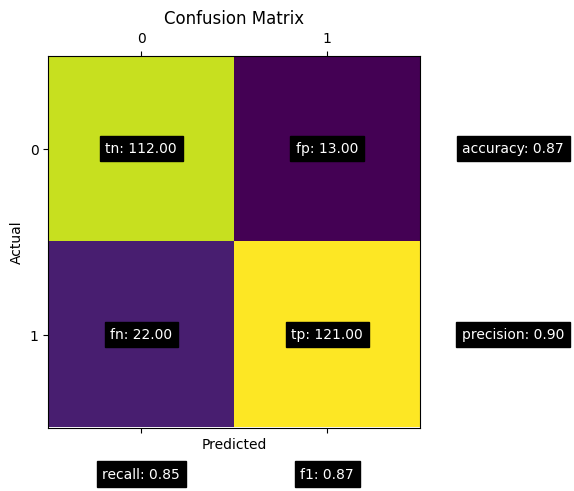

In [ ]:
#Use this cell for developing or evaluating model_1.

'''
Descision Tree/Random forest
'''

# we'll use the svded tfidf vectors, the topic distributions, the sentiments and the mentions and hashtags counts as features
X = pd.concat([svd_tfidf_df, topicdf, mdf['sentiment'], mdf['mentions_count'], mdf['hashtags_count']], axis=1)
y = mdf['misinformation']

# we'll split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# we'll use a random forest classifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
render_cm(cm)



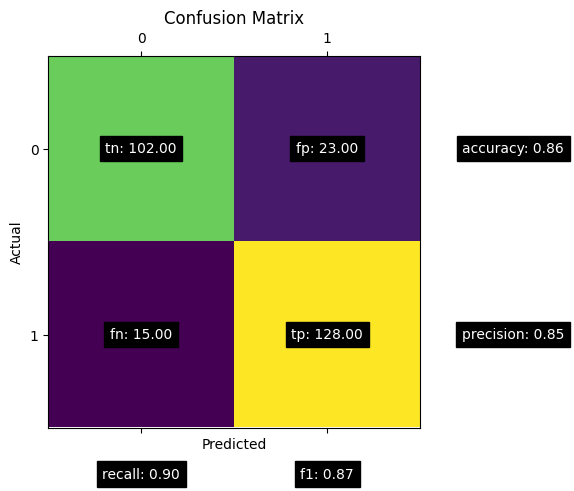

In [ ]:
'''
Logistic Regression
'''

# we'll use the svded tfidf vectors, the topic distributions, the sentiments and the mentions and hashtags counts as features
X = pd.concat([svd_tfidf_df, topicdf, mdf['sentiment'], mdf['mentions_count'], mdf['hashtags_count']], axis=1)
y = mdf['misinformation']

# we'll split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# we'll use a logistic regression classifier
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
render_cm(cm)

In [ ]:
'''
NNs 1: Multiplayer perceptron applied to the token vectors
'''
# run it on the token vectors to start
X = tokenvectorsdf
y = mdf['misinformation']


# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# create the model
clf = MLPClassifier(random_state=1, max_iter=600).fit(X_train, y_train)
# evaluate the model
print(clf.score(X_test, y_test))


0.7601809954751131


c:\ProgramData\miniconda3\envs\bism\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
'''
NNs 2: LSTM on token vectors - not expecting this to perform well - no temporal structure in the token vectors
'''
# LSTM
X = np.array(tokenvectorsdf)
X = X.reshape((X.shape[0], 1, X.shape[1]))  # Reshaping for LSTM input

y = mdf['misinformation'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=64)
_, accuracy = model.evaluate(X_test, y_test)
print(f"LSTM Model Accuracy: {accuracy}")

C:\Users\seems\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5138 - loss: 0.6930
Epoch 2/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5271 - loss: 0.6923 
Epoch 3/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5379 - loss: 0.6924 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4842 - loss: 0.6930  
LSTM Model Accuracy: 0.49321267008781433


Epoch 1/10


C:\Users\seems\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.4953 - loss: 0.6938
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5257 - loss: 0.6932
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5008 - loss: 0.6965
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5080 - loss: 0.6928
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5193 - loss: 0.6928
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5192 - loss: 0.6939
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5096 - loss: 0.6957
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5157 - loss: 0.6929
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4986 - loss: 0.6937
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5123 - loss: 0.6928
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4842 - loss: 0.6937
LSTM Model Accuracy: 0.49321267008781433
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


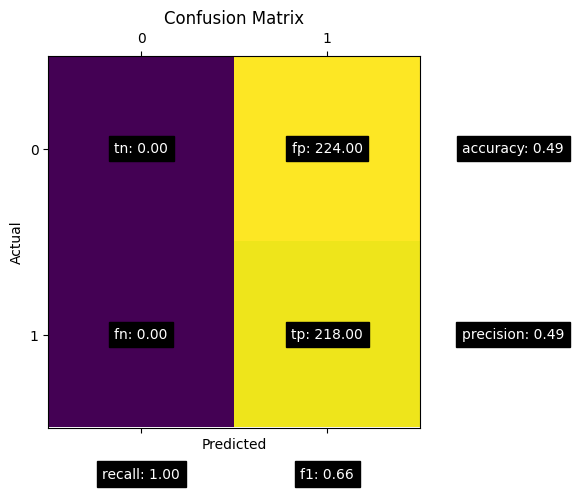

In [ ]:
'''
NN's 3: lstm with pos tags included - this might detect some sort of translation or low effort or spammy posts
translation/native language might have some impact on the credibility of the post (although there might be an ethical consideration here)

The model will be trained on the pos tags column (which is a list of indices) only
'''
X = np.array(mdf['pos_tags_array'].tolist())
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshaping for LSTM input
y = mdf['misinformation'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = Sequential()
model.add(Dense(1, activation='sigmoid'))
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='sigmoid')) # we'll add another layer to see if it helps
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=64)
_, accuracy = model.evaluate(X_test, y_test)
print(f"LSTM Model Accuracy: {accuracy}")

# lets get (and plot) a confusion matrix
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
cm = confusion_matrix(y_test, y_pred)
render_cm(cm)




In [ ]:
'''Composite Models'''

'''Composite one:'''


'Composite Models'

.
.
.

In [ ]:
#Use this cell for developing or evaluating model_N.

# here we'll create a confusion matrix for the each model


# Model building & evaluation
Once you have found the most optimal model, you should only show the model building and evaluation here!

In this cell, in no more than 300 words, you can elaborate on development and performance of your best model.

In [ ]:
#Use this cell for the best models building & evaluation.

# Kfold cross validation